# Visualization notebook for Learning Curves approach

**NB:** Whenever there is a "Complete", one must fill it with the corresponding outputs after running the code on the cluster (to copy-paste from the terminal)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import seaborn as sns
import evaluate
import regex as re
import io
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from transformers import AutoModelForSequenceClassification, AutoTokenizer, DataCollatorWithPadding, TrainingArguments
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from datasets import load_metric

**Complete below for training loss**

In [19]:
experience = '''
   N_training_examples  Mean_Train_Loss  Lower_CI  Upper_CI
0                    0         0.452153  0.266977  0.497380
1                    1         0.244964  0.087940  0.482616
2                    2         0.092610  0.024209  0.341172
3                    3         0.048422  0.020192  0.192095
'''

feeling = '''
   N_training_examples  Mean_Train_Loss  Lower_CI  Upper_CI
0                    0         0.420957  0.250706  0.485837
1                    1         0.112048  0.042959  0.315106
2                    2         0.036995  0.014872  0.082965
3                    3         0.014267  0.005653  0.038296
'''

difficulty = '''
   N_training_examples  Mean_Train_Loss  Lower_CI  Upper_CI
0                    0         0.459152  0.395667  0.486583
1                    1         0.215715  0.079228  0.480494
2                    2         0.076522  0.020098  0.260064
3                    3         0.023963  0.006871  0.081593
'''

belief = '''
   N_training_examples  Mean_Train_Loss  Lower_CI  Upper_CI
0                    0         0.369550  0.235591  0.430314
1                    1         0.173289  0.061303  0.409175
2                    2         0.104757  0.022986  0.359840
3                    3         0.052307  0.008144  0.243696
''' 

intention = '''
   N_training_examples  Mean_Train_Loss  Lower_CI  Upper_CI
0                    0         0.136608  0.071688  0.151987
1                    1         0.073621  0.020391  0.148367
2                    2         0.028374  0.002939  0.104622
3                    3         0.025634  0.001567  0.128439
'''

perspective = '''
   N_training_examples  Mean_Train_Loss  Lower_CI  Upper_CI
0                    0         0.153617  0.128321  0.164304
1                    1         0.119570  0.039795  0.144190
2                    2         0.063225  0.019452  0.120791
3                    3         0.028861  0.006223  0.077439
'''

learning = '''
   N_training_examples  Mean_Train_Loss  Lower_CI  Upper_CI
0                    0         0.116810  0.111651  0.123909
1                    1         0.108350  0.053580  0.122213
2                    2         0.053684  0.013979  0.124229
3                    3         0.029757  0.007340  0.094588
'''

In [20]:
dfs_train = {}

# Convert the string data to a file-like object and read the data into a pandas DataFrame
dfs_train['Experience'] = pd.read_csv(io.StringIO(experience), delim_whitespace=True)
dfs_train['Feeling'] = pd.read_csv(io.StringIO(feeling), delim_whitespace=True)
dfs_train['Difficulty'] = pd.read_csv(io.StringIO(difficulty), delim_whitespace=True)
dfs_train['Belief'] = pd.read_csv(io.StringIO(belief), delim_whitespace=True)
dfs_train['Intention'] = pd.read_csv(io.StringIO(intention), delim_whitespace=True)
dfs_train['Perspective'] = pd.read_csv(io.StringIO(perspective), delim_whitespace=True)
dfs_train['Learning'] = pd.read_csv(io.StringIO(learning), delim_whitespace=True)

dfs_train['Experience'].head()

,N_training_examples,Mean_Train_Loss,Lower_CI,Upper_CI
0,0,0.452153,0.266977,0.497380
1,1,0.244964,0.087940,0.482616
2,2,0.092610,0.024209,0.341172
3,3,0.048422,0.020192,0.192095


**Complete below for val loss**

In [21]:
experience = '''
   N_training_examples  Mean_Val_Loss  Lower_CI  Upper_CI
0                    0       0.481620  0.375164  0.517499
1                    1       0.386384  0.307811  0.513143
2                    2       0.395942  0.316644  0.451224
3                    3       0.399098  0.322912  0.458892
'''

feeling = '''
   N_training_examples  Mean_Val_Loss  Lower_CI  Upper_CI
0                    0       0.439447  0.296233  0.504777
1                    1       0.205748  0.159075  0.314340
2                    2       0.178853  0.142800  0.215290
3                    3       0.187740  0.141814  0.224094
'''

difficulty = '''
   N_training_examples  Mean_Val_Loss  Lower_CI  Upper_CI
0                    0       0.416743  0.367640  0.454084
1                    1       0.322288  0.271021  0.417291
2                    2       0.339747  0.269014  0.400072
3                    3       0.359514  0.277504  0.424620
'''

belief = '''
   N_training_examples  Mean_Val_Loss  Lower_CI  Upper_CI
0                    0       0.367717  0.295502  0.411521
1                    1       0.313271  0.262280  0.405198
2                    2       0.321783  0.285590  0.368521
3                    3       0.336398  0.273109  0.396560
'''

intention = '''
   N_training_examples  Mean_Val_Loss  Lower_CI  Upper_CI
0                    0       0.159562  0.109487  0.172148
1                    1       0.104289  0.077938  0.153645
2                    2       0.097576  0.076262  0.133994
3                    3       0.094345  0.077534  0.154074
'''

perspective = '''
   N_training_examples  Mean_Val_Loss  Lower_CI  Upper_CI
0                    0       0.118554  0.107444  0.120934
1                    1       0.107311  0.084910  0.120533
2                    2       0.093327  0.078955  0.109361
3                    3       0.098523  0.085684  0.120338
'''

learning = '''
   N_training_examples  Mean_Val_Loss  Lower_CI  Upper_CI
0                    0       0.178073  0.171058  0.183976
1                    1       0.155560  0.100366  0.176497
2                    2       0.110459  0.064690  0.176633
3                    3       0.089997  0.065960  0.118855
'''

In [22]:
dfs_val = {}

# Convert the string data to a file-like object and read the data into a pandas DataFrame
dfs_val['Experience'] = pd.read_csv(io.StringIO(experience), delim_whitespace=True)
dfs_val['Feeling'] = pd.read_csv(io.StringIO(feeling), delim_whitespace=True)
dfs_val['Difficulty'] = pd.read_csv(io.StringIO(difficulty), delim_whitespace=True)
dfs_val['Belief'] = pd.read_csv(io.StringIO(belief), delim_whitespace=True)
dfs_val['Intention'] = pd.read_csv(io.StringIO(intention), delim_whitespace=True)
dfs_val['Perspective'] = pd.read_csv(io.StringIO(perspective), delim_whitespace=True)
dfs_val['Learning'] = pd.read_csv(io.StringIO(learning), delim_whitespace=True)

dfs_val['Experience'].head()

,N_training_examples,Mean_Val_Loss,Lower_CI,Upper_CI
0,0,0.481620,0.375164,0.517499
1,1,0.386384,0.307811,0.513143
2,2,0.395942,0.316644,0.451224
3,3,0.399098,0.322912,0.458892


**Complete below for train acc**

In [23]:
experience = '''
   N_training_examples  Mean_Train_Acc  Lower_CI  Upper_CI
0                    0        0.818000  0.806000  0.897900
1                    1        0.910900  0.814000  0.974875
2                    2        0.967667  0.861733  0.994067
3                    3        0.984850  0.929700  0.995000
'''

feeling = '''
   N_training_examples  Mean_Train_Acc  Lower_CI  Upper_CI
0                    0        0.831200  0.816000  0.914000
1                    1        0.960500  0.845900  0.990100
2                    2        0.990267  0.976300  0.996883
3                    3        0.996700  0.991012  0.999000
'''

difficulty = '''
   N_training_examples  Mean_Train_Acc  Lower_CI  Upper_CI
0                    0        0.819200  0.816000  0.830400
1                    1        0.920800  0.814225  0.973000
2                    2        0.973533  0.897600  0.995033
3                    3        0.993950  0.977762  0.999388
'''

belief = '''
   N_training_examples  Mean_Train_Acc  Lower_CI  Upper_CI
0                    0          0.8528  0.850000  0.864000
1                    1          0.9367  0.855000  0.983875
2                    2          0.9620  0.856867  0.995333
3                    3          0.9808  0.896375  0.997888
'''

intention = '''
   N_training_examples  Mean_Train_Acc  Lower_CI  Upper_CI
0                    0        0.966000   0.96600  0.966000
1                    1        0.973600   0.96300  0.993775
2                    2        0.991267   0.96675  0.999700
3                    3        0.993500   0.97025  0.999888
'''

perspective = '''
   N_training_examples  Mean_Train_Acc  Lower_CI  Upper_CI
0                    0        0.964000  0.964000  0.964000
1                    1        0.970500  0.968000  0.985500
2                    2        0.979667  0.966667  0.994433
3                    3        0.991600  0.974500  0.998388
'''

learning = '''
   N_training_examples  Mean_Train_Acc  Lower_CI  Upper_CI
0                    0         0.97600  0.976000  0.976000
1                    1         0.97550  0.974000  0.985625
2                    2         0.98700  0.973333  0.997183
3                    3         0.99225  0.974263  0.998500
'''

In [24]:
dfs_train_acc = {}

# Convert the string data to a file-like object and read the data into a pandas DataFrame
dfs_train_acc['Experience'] = pd.read_csv(io.StringIO(experience), delim_whitespace=True)
dfs_train_acc['Feeling'] = pd.read_csv(io.StringIO(feeling), delim_whitespace=True)
dfs_train_acc['Difficulty'] = pd.read_csv(io.StringIO(difficulty), delim_whitespace=True)
dfs_train_acc['Belief'] = pd.read_csv(io.StringIO(belief), delim_whitespace=True)
dfs_train_acc['Intention'] = pd.read_csv(io.StringIO(intention), delim_whitespace=True)
dfs_train_acc['Perspective'] = pd.read_csv(io.StringIO(perspective), delim_whitespace=True)
dfs_train_acc['Learning'] = pd.read_csv(io.StringIO(learning), delim_whitespace=True)

dfs_train_acc['Experience'].head()

,N_training_examples,Mean_Train_Acc,Lower_CI,Upper_CI
0,0,0.818000,0.806000,0.897900
1,1,0.910900,0.814000,0.974875
2,2,0.967667,0.861733,0.994067
3,3,0.984850,0.929700,0.995000


**Complete below for val acc**

In [25]:
experience = '''
   N_training_examples  Mean_Val_Acc  Lower_CI  Upper_CI
0                    0      0.795367  0.789575  0.834459
1                    1      0.840541  0.789575  0.869788
2                    2      0.875483  0.865299  0.889093
3                    3      0.885521  0.871959  0.895319
'''

feeling = '''
   N_training_examples  Mean_Val_Acc  Lower_CI  Upper_CI
0                    0      0.816988  0.797297  0.898938
1                    1      0.921429  0.825531  0.943581
2                    2      0.941506  0.929440  0.951303
3                    3      0.950386  0.942954  0.955598
'''

difficulty = '''
   N_training_examples  Mean_Val_Acc  Lower_CI  Upper_CI
0                    0      0.850000  0.840878  0.851351
1                    1      0.871622  0.843871  0.890154
2                    2      0.884170  0.870029  0.903427
3                    3      0.897104  0.882674  0.912693
'''

belief = '''
   N_training_examples  Mean_Val_Acc  Lower_CI  Upper_CI
0                    0      0.856371  0.855212  0.864189
1                    1      0.879730  0.855212  0.899180
2                    2      0.886486  0.856950  0.902606
3                    3      0.897490  0.872201  0.916554
'''

intention = '''
   N_training_examples  Mean_Val_Acc  Lower_CI  Upper_CI
0                    0      0.959459  0.959459  0.959459
1                    1      0.964672  0.959459  0.974903
2                    2      0.973745  0.960763  0.982625
3                    3      0.975869  0.961631  0.982191
'''

perspective = '''
   N_training_examples  Mean_Val_Acc  Lower_CI  Upper_CI
0                    0      0.974903  0.974903  0.974903
1                    1      0.974324  0.968919  0.976400
2                    2      0.972587  0.967181  0.977896
3                    3      0.971042  0.963320  0.979826
'''

learning = '''
   N_training_examples  Mean_Val_Acc  Lower_CI  Upper_CI
0                    0      0.959459  0.959459  0.959459
1                    1      0.960618  0.959459  0.968436
2                    2      0.969691  0.959459  0.981757
3                    3      0.974517  0.963562  0.981757
'''

In [26]:
dfs_val_acc = {}

# Convert the string data to a file-like object and read the data into a pandas DataFrame
dfs_val_acc['Experience'] = pd.read_csv(io.StringIO(experience), delim_whitespace=True)
dfs_val_acc['Feeling'] = pd.read_csv(io.StringIO(feeling), delim_whitespace=True)
dfs_val_acc['Difficulty'] = pd.read_csv(io.StringIO(difficulty), delim_whitespace=True)
dfs_val_acc['Belief'] = pd.read_csv(io.StringIO(belief), delim_whitespace=True)
dfs_val_acc['Intention'] = pd.read_csv(io.StringIO(intention), delim_whitespace=True)
dfs_val_acc['Perspective'] = pd.read_csv(io.StringIO(perspective), delim_whitespace=True)
dfs_val_acc['Learning'] = pd.read_csv(io.StringIO(learning), delim_whitespace=True)

dfs_val_acc['Experience'].head()

,N_training_examples,Mean_Val_Acc,Lower_CI,Upper_CI
0,0,0.795367,0.789575,0.834459
1,1,0.840541,0.789575,0.869788
2,2,0.875483,0.865299,0.889093
3,3,0.885521,0.871959,0.895319


**Complete below for balanced train acc**

In [27]:
experience = '''
   N_training_examples  Mean_Train_Balanced_Acc  Lower_CI  Upper_CI
0                    0                 0.533276  0.500000  0.755056
1                    1                 0.786823  0.500000  0.950866
2                    2                 0.929721  0.665191  0.988579
3                    3                 0.973153  0.880525  0.992319
'''

feeling = '''
   N_training_examples  Mean_Train_Balanced_Acc  Lower_CI  Upper_CI
0                    0                 0.546776  0.500000  0.804083
1                    1                 0.913120  0.602740  0.981095
2                    2                 0.981633  0.950909  0.993453
3                    3                 0.993693  0.983701  0.997297
'''

difficulty = '''
   N_training_examples  Mean_Train_Balanced_Acc  Lower_CI  Upper_CI
0                    0                 0.505006  0.499053  0.538063
1                    1                 0.812270  0.499525  0.959723
2                    2                 0.947657  0.793827  0.989852
3                    3                 0.987609  0.953018  0.999382
'''

belief = '''
   N_training_examples  Mean_Train_Balanced_Acc  Lower_CI  Upper_CI
0                    0                 0.510431  0.500000  0.555176
1                    1                 0.821240  0.500000  0.967662
2                    2                 0.891440  0.527307  0.989777
3                    3                 0.950809  0.715210  0.995691
'''

intention = '''
   N_training_examples  Mean_Train_Balanced_Acc  Lower_CI  Upper_CI
0                    0                 0.500000  0.500000  0.500000
1                    1                 0.673130  0.500000  0.944791
2                    2                 0.933160  0.600547  0.999844
3                    3                 0.936659  0.605927  0.999708
'''

perspective = '''
   N_training_examples  Mean_Train_Balanced_Acc  Lower_CI  Upper_CI
0                    0                 0.500000  0.500000  0.500000
1                    1                 0.546617  0.500000  0.831983
2                    2                 0.750034  0.500000  0.969043
3                    3                 0.937135  0.798688  0.985280
'''

learning = '''
   N_training_examples  Mean_Train_Balanced_Acc  Lower_CI  Upper_CI
0                    0                 0.500000  0.500000  0.500000
1                    1                 0.532590  0.500000  0.752570
2                    2                 0.770839  0.500000  0.971503
3                    3                 0.901521  0.591029  0.983076
'''

In [28]:
dfs_train_balanced_acc = {}

# Convert the string data to a file-like object and read the data into a pandas DataFrame
dfs_train_balanced_acc['Experience'] = pd.read_csv(io.StringIO(experience), delim_whitespace=True)
dfs_train_balanced_acc['Feeling'] = pd.read_csv(io.StringIO(feeling), delim_whitespace=True)
dfs_train_balanced_acc['Difficulty'] = pd.read_csv(io.StringIO(difficulty), delim_whitespace=True)
dfs_train_balanced_acc['Belief'] = pd.read_csv(io.StringIO(belief), delim_whitespace=True)
dfs_train_balanced_acc['Intention'] = pd.read_csv(io.StringIO(intention), delim_whitespace=True)
dfs_train_balanced_acc['Perspective'] = pd.read_csv(io.StringIO(perspective), delim_whitespace=True)
dfs_train_balanced_acc['Learning'] = pd.read_csv(io.StringIO(learning), delim_whitespace=True)

dfs_train_balanced_acc['Experience'].head()

,N_training_examples,Mean_Train_Balanced_Acc,Lower_CI,Upper_CI
0,0,0.533276,0.500000,0.755056
1,1,0.786823,0.500000,0.950866
2,2,0.929721,0.665191,0.988579
3,3,0.973153,0.880525,0.992319


**Complete below for balanced val acc**

In [29]:
experience = '''
   N_training_examples  Mean_Val_Balanced_Acc  Lower_CI  Upper_CI
0                    0               0.523519  0.500000  0.682272
1                    1               0.703872  0.500000  0.814746
2                    2               0.797330  0.724665  0.823500
3                    3               0.815126  0.744199  0.840691
'''

feeling = '''
   N_training_examples  Mean_Val_Balanced_Acc  Lower_CI  Upper_CI
0                    0               0.554253  0.500000  0.784984
1                    1               0.844899  0.583789  0.897145
2                    2               0.906142  0.889911  0.923295
3                    3               0.926271  0.912300  0.936098
'''

difficulty = '''
   N_training_examples  Mean_Val_Balanced_Acc  Lower_CI  Upper_CI
0                    0               0.516893  0.500000  0.630924
1                    1               0.696279  0.500000  0.811392
2                    2               0.765286  0.665592  0.805280
3                    3               0.798073  0.771021  0.837928
'''

belief = '''
   N_training_examples  Mean_Val_Balanced_Acc  Lower_CI  Upper_CI
0                    0               0.505108  0.500000  0.539584
1                    1               0.700965  0.500000  0.773935
2                    2               0.732051  0.533413  0.818731
3                    3               0.775589  0.700325  0.796149
'''

intention = '''
   N_training_examples  Mean_Val_Balanced_Acc  Lower_CI  Upper_CI
0                    0               0.500000  0.500000  0.500000
1                    1               0.623575  0.500000  0.839839
2                    2               0.794769  0.567379  0.851207
3                    3               0.804997  0.562701  0.853898
'''

perspective = '''
   N_training_examples  Mean_Val_Balanced_Acc  Lower_CI  Upper_CI
0                    0               0.500000  0.500000  0.500000
1                    1               0.525933  0.500000  0.679827
2                    2               0.626215  0.498465  0.716076
3                    3               0.711607  0.645059  0.759652
'''

learning = '''
   N_training_examples  Mean_Val_Balanced_Acc  Lower_CI  Upper_CI
0                    0               0.500000  0.500000  0.500000
1                    1               0.518846  0.500000  0.646060
2                    2               0.660396  0.500000  0.819500
3                    3               0.749564  0.666893  0.824631
'''

In [30]:
dfs_val_balanced_acc = {}

# Convert the string data to a file-like object and read the data into a pandas DataFrame
dfs_val_balanced_acc['Experience'] = pd.read_csv(io.StringIO(experience), delim_whitespace=True)
dfs_val_balanced_acc['Feeling'] = pd.read_csv(io.StringIO(feeling), delim_whitespace=True)
dfs_val_balanced_acc['Difficulty'] = pd.read_csv(io.StringIO(difficulty), delim_whitespace=True)
dfs_val_balanced_acc['Belief'] = pd.read_csv(io.StringIO(belief), delim_whitespace=True)
dfs_val_balanced_acc['Intention'] = pd.read_csv(io.StringIO(intention), delim_whitespace=True)
dfs_val_balanced_acc['Perspective'] = pd.read_csv(io.StringIO(perspective), delim_whitespace=True)
dfs_val_balanced_acc['Learning'] = pd.read_csv(io.StringIO(learning), delim_whitespace=True)

dfs_val_balanced_acc['Experience'].head()

,N_training_examples,Mean_Val_Balanced_Acc,Lower_CI,Upper_CI
0,0,0.523519,0.500000,0.682272
1,1,0.703872,0.500000,0.814746
2,2,0.797330,0.724665,0.823500
3,3,0.815126,0.744199,0.840691


**Complete below for average test confidence**

Mean confidence scores of the last epoch

In [31]:
experience = '''
   N_training_examples  Mean_Test_Conf  Lower_CI  Upper_CI
0                    0        0.814133  0.769036  0.871877
1                    1        0.885601  0.806544  0.936874
2                    2        0.944850  0.858194  0.967434
3                    3        0.961125  0.905735  0.979233
'''

feeling = '''
   N_training_examples  Mean_Test_Conf  Lower_CI  Upper_CI
0                    0        0.831444  0.788400  0.894149
1                    1        0.939400  0.835184  0.971531
2                    2        0.974432  0.954218  0.984831
3                    3        0.984053  0.975771  0.987770
'''

difficulty = '''
   N_training_examples  Mean_Test_Conf  Lower_CI  Upper_CI
0                    0        0.798090  0.703495  0.849550
1                    1        0.898544  0.810045  0.943718
2                    2        0.949433  0.910139  0.969412
3                    3        0.969519  0.953646  0.975136
'''

belief = '''
   N_training_examples  Mean_Test_Conf  Lower_CI  Upper_CI
0                    0        0.848996  0.819529  0.887019
1                    1        0.912130  0.846543  0.955135
2                    2        0.935376  0.830837  0.971169
3                    3        0.959408  0.886826  0.978981
'''

intention = '''
   N_training_examples  Mean_Test_Conf  Lower_CI  Upper_CI
0                    0        0.967829  0.962032  0.972492
1                    1        0.974738  0.963842  0.990407
2                    2        0.981255  0.931139  0.993282
3                    3        0.989414  0.968420  0.996122
'''

perspective = '''
   N_training_examples  Mean_Test_Conf  Lower_CI  Upper_CI
0                    0        0.965671  0.955831  0.971161
1                    1        0.968740  0.960473  0.978200
2                    2        0.972719  0.950916  0.986903
3                    3        0.984927  0.972626  0.991538
'''

learning = '''
   N_training_examples  Mean_Test_Conf  Lower_CI  Upper_CI
0                    0        0.978606  0.972430  0.982468
1                    1        0.975484  0.969711  0.979416
2                    2        0.983825  0.976289  0.991497
3                    3        0.983007  0.947349  0.993902
'''

In [32]:
dfs_test_confidence = {}

# Convert the string data to a file-like object and read the data into a pandas DataFrame
dfs_test_confidence['Experience'] = pd.read_csv(io.StringIO(experience), delim_whitespace=True)
dfs_test_confidence['Feeling'] = pd.read_csv(io.StringIO(feeling), delim_whitespace=True)
dfs_test_confidence['Difficulty'] = pd.read_csv(io.StringIO(difficulty), delim_whitespace=True)
dfs_test_confidence['Belief'] = pd.read_csv(io.StringIO(belief), delim_whitespace=True)
dfs_test_confidence['Intention'] = pd.read_csv(io.StringIO(intention), delim_whitespace=True)
dfs_test_confidence['Perspective'] = pd.read_csv(io.StringIO(perspective), delim_whitespace=True)
dfs_test_confidence['Learning'] = pd.read_csv(io.StringIO(learning), delim_whitespace=True)

dfs_test_confidence['Experience'].head()

,N_training_examples,Mean_Test_Conf,Lower_CI,Upper_CI
0,0,0.814133,0.769036,0.871877
1,1,0.885601,0.806544,0.936874
2,2,0.944850,0.858194,0.967434
3,3,0.961125,0.905735,0.979233


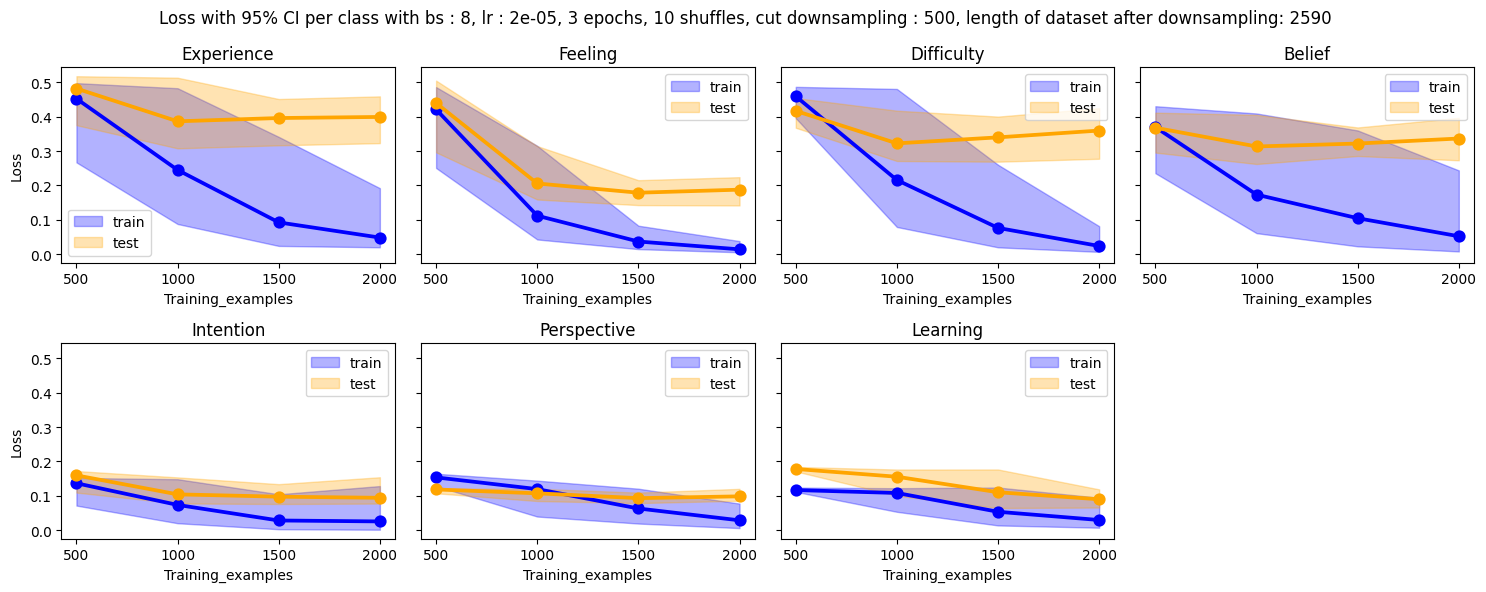

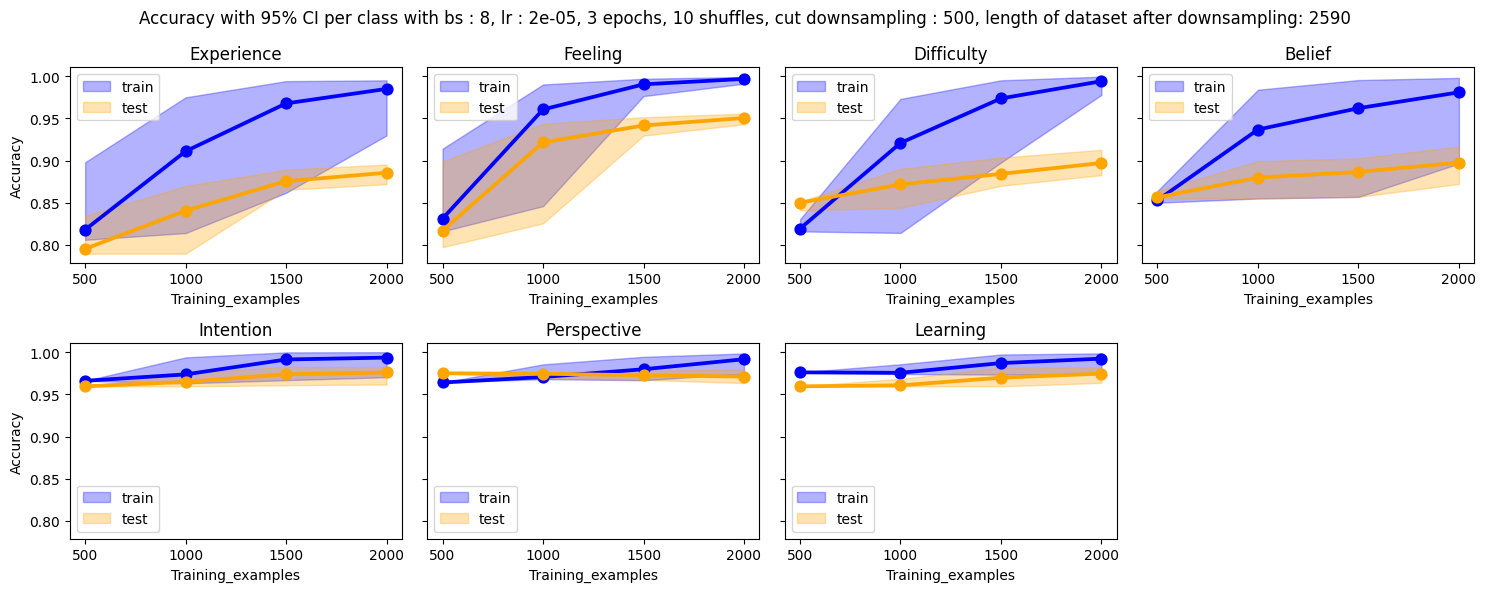

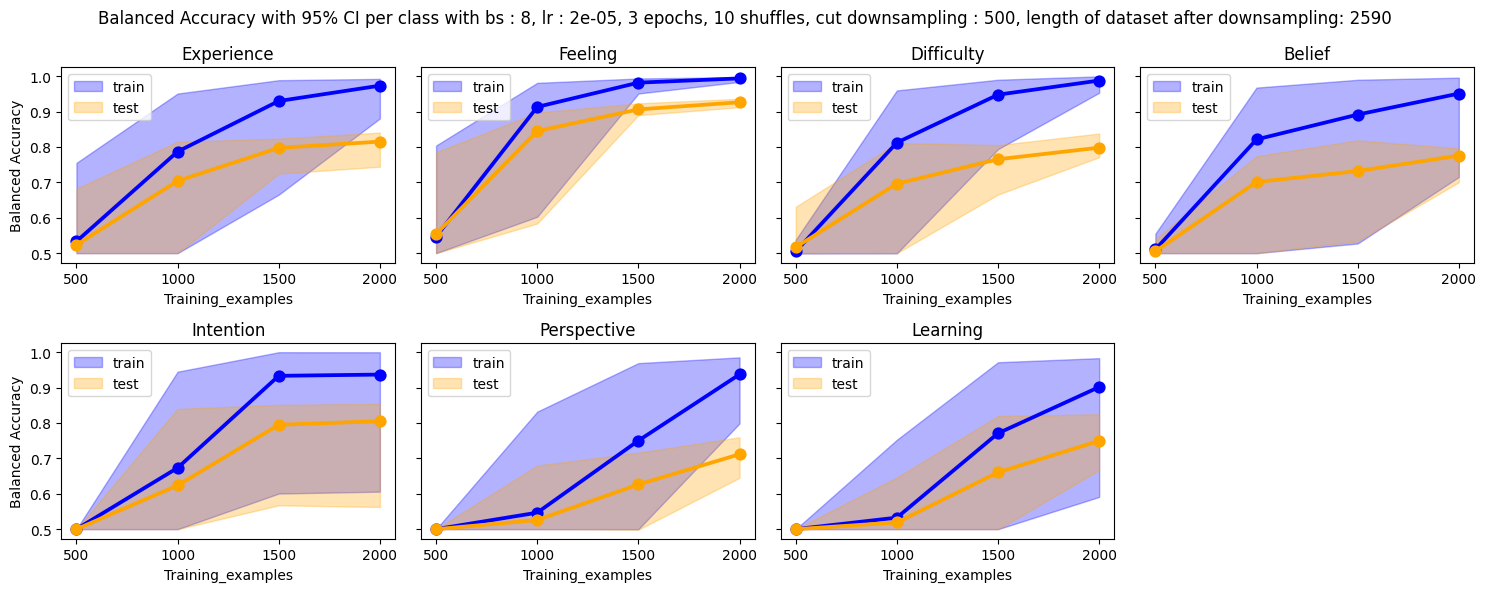

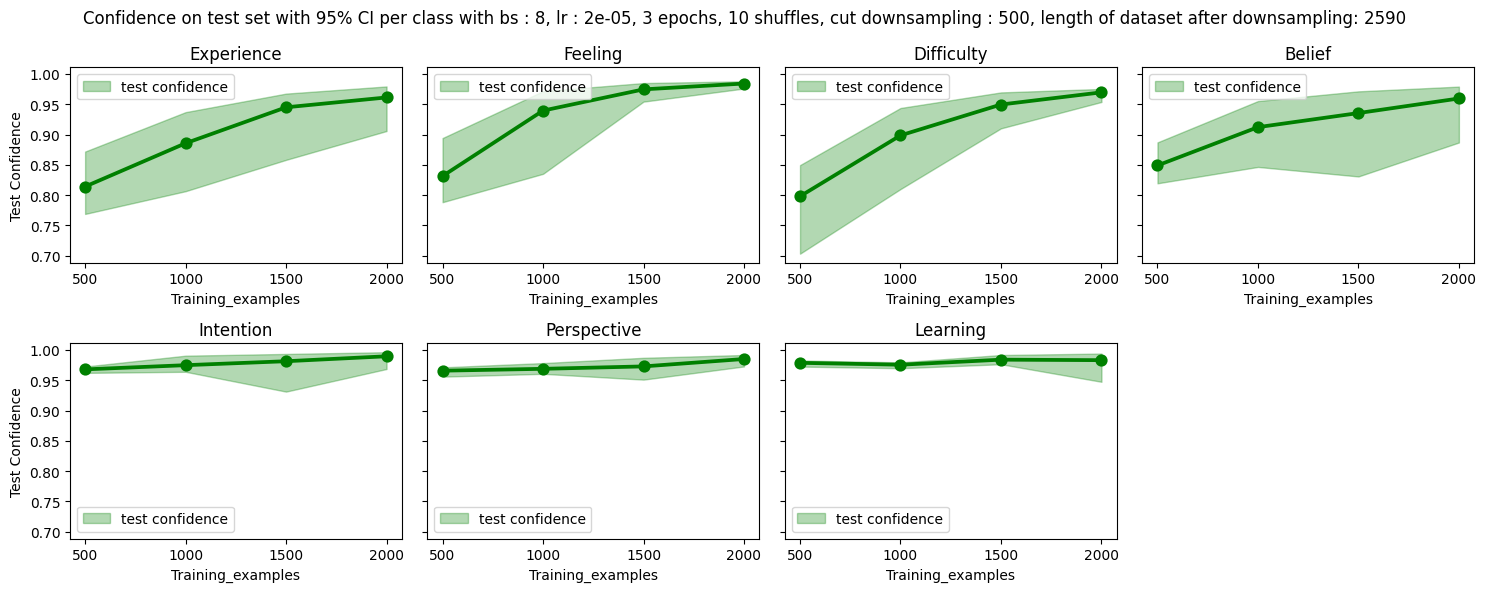

In [34]:
###### to copy from file ######
dataset_size = 2590

reflective_categories = ['Experience', 'Feeling', 'Difficulty', 'Belief', 'Intention', 'Perspective', 'Learning']
topN = 7
epochs = 3
N_shuffle_total = 10
batch_size = 8
learning_rate = 2e-05
cut_downsampling = 500
training_examples = [500, 1000, 1500, 2000]


#####################

fig, axs = plt.subplots(2, 4, figsize=(15, 6), sharey = True)  

# Sample iteration over the dictionary to plot subplots
for i, cat in enumerate(reflective_categories):
    df_train = dfs_train[cat]
    df_val = dfs_val[cat]
    ax = axs[i // 4, i % 4]
    
    # Mean lineplot
    sns.pointplot(data=df_train, x='N_training_examples', y='Mean_Train_Loss', color='blue', ax = ax)
    sns.pointplot(data=df_val, x='N_training_examples', y='Mean_Val_Loss', color='orange', ax = ax) 
    
    # Fill between the confidence interval
    ax.fill_between(df_train['N_training_examples'], df_train['Lower_CI'], df_train['Upper_CI'], color='blue', alpha=0.3, label = 'train')
    ax.fill_between(df_val['N_training_examples'], df_val['Lower_CI'], df_val['Upper_CI'], color='orange', alpha=0.3, label = 'test')

    ax.set_xticks(np.arange(len(training_examples)), training_examples)
    ax.set_xlabel('Training_examples')
    ax.set_ylabel("Loss")
    ax.set_title(f"{cat}") 
    ax.legend()
    
fig.delaxes(axs[1, 3])
plt.suptitle(f"Loss with 95% CI per class with bs : {batch_size}, lr : {learning_rate}, {epochs} epochs, {N_shuffle_total} shuffles, cut downsampling : {cut_downsampling}, length of dataset after downsampling: {dataset_size}")
plt.tight_layout()
plt.show()

fig, axs = plt.subplots(2, 4, figsize=(15, 6), sharey = True)  

# Sample iteration over the dictionary to plot subplots
for i, cat in enumerate(reflective_categories):
    df_train = dfs_train_acc[cat]
    df_acc = dfs_val_acc[cat]
    #df_test_conf = dfs_test_confidence[cat]
    ax = axs[i // 4, i % 4]
    
    # Mean lineplot
    sns.pointplot(data=df_train, x='N_training_examples', y='Mean_Train_Acc', color='blue', ax = ax)
    sns.pointplot(data=df_acc, x='N_training_examples', y='Mean_Val_Acc', color='orange', ax = ax) 
    #sns.pointplot(data=df_test_conf, x='N_training_examples', y='Mean_Test_Conf', color='green', ax = ax) 
    
    # Fill between the confidence interval
    ax.fill_between(df_train['N_training_examples'], df_train['Lower_CI'], df_train['Upper_CI'], color='blue', alpha=0.3, label = 'train')
    ax.fill_between(df_acc['N_training_examples'], df_acc['Lower_CI'], df_acc['Upper_CI'], color='orange', alpha=0.3, label = 'test')
    #ax.fill_between(df_test_conf['N_training_examples'], df_test_conf['Lower_CI'], df_test_conf['Upper_CI'], color='green', alpha=0.3, label = 'test confidence')
    
    ax.set_xticks(np.arange(len(training_examples)), training_examples)
    ax.set_xlabel('Training_examples')
    ax.set_ylabel("Accuracy")
    ax.set_title(f"{cat}") 
    ax.legend()

fig.delaxes(axs[1, 3])
plt.suptitle(f"Accuracy with 95% CI per class with bs : {batch_size}, lr : {learning_rate}, {epochs} epochs, {N_shuffle_total} shuffles, cut downsampling : {cut_downsampling}, length of dataset after downsampling: {dataset_size}")
plt.tight_layout()
plt.show()

fig, axs = plt.subplots(2, 4, figsize=(15, 6), sharey = True)  

# Sample iteration over the dictionary to plot subplots
for i, cat in enumerate(reflective_categories):
    df_train = dfs_train_balanced_acc[cat]
    df_acc = dfs_val_balanced_acc[cat]
    #df_test_conf = dfs_test_confidence[cat]
    ax = axs[i // 4, i % 4]
    
    # Mean lineplot
    sns.pointplot(data=df_train, x='N_training_examples', y='Mean_Train_Balanced_Acc', color='blue', ax = ax)
    sns.pointplot(data=df_acc, x='N_training_examples', y='Mean_Val_Balanced_Acc', color='orange', ax = ax) 
    #sns.pointplot(data=df_test_conf, x='N_training_examples', y='Mean_Test_Conf', color='green', ax = ax) 
    
    # Fill between the confidence interval
    ax.fill_between(df_train['N_training_examples'], df_train['Lower_CI'], df_train['Upper_CI'], color='blue', alpha=0.3, label = 'train')
    ax.fill_between(df_acc['N_training_examples'], df_acc['Lower_CI'], df_acc['Upper_CI'], color='orange', alpha=0.3, label = 'test')
    #ax.fill_between(df_test_conf['N_training_examples'], df_test_conf['Lower_CI'], df_test_conf['Upper_CI'], color='green', alpha=0.3, label = 'test confidence')
    
    ax.set_xticks(np.arange(len(training_examples)), training_examples)
    ax.set_xlabel('Training_examples')
    ax.set_ylabel("Balanced Accuracy")
    ax.set_title(f"{cat}") 
    ax.legend()

fig.delaxes(axs[1, 3])
plt.suptitle(f"Balanced Accuracy with 95% CI per class with bs : {batch_size}, lr : {learning_rate}, {epochs} epochs, {N_shuffle_total} shuffles, cut downsampling : {cut_downsampling}, length of dataset after downsampling: {dataset_size}")
plt.tight_layout()
plt.show()

fig, axs = plt.subplots(2, 4, figsize=(15, 6), sharey = True)  

# Sample iteration over the dictionary to plot subplots
for i, cat in enumerate(reflective_categories):
    df_test_conf = dfs_test_confidence[cat]
    ax = axs[i // 4, i % 4]
    
    # Mean lineplot
    sns.pointplot(data=df_test_conf, x='N_training_examples', y='Mean_Test_Conf', color='green', ax = ax) 
    
    # Fill between the confidence interval
    ax.fill_between(df_test_conf['N_training_examples'], df_test_conf['Lower_CI'], df_test_conf['Upper_CI'], color='green', alpha=0.3, label = 'test confidence')
    
    ax.set_xticks(np.arange(len(training_examples)), training_examples)
    ax.set_xlabel('Training_examples')
    ax.set_ylabel("Test Confidence")
    ax.set_title(f"{cat}") 
    ax.legend()

fig.delaxes(axs[1, 3])
plt.suptitle(f"Confidence on test set with 95% CI per class with bs : {batch_size}, lr : {learning_rate}, {epochs} epochs, {N_shuffle_total} shuffles, cut downsampling : {cut_downsampling}, length of dataset after downsampling: {dataset_size}")
plt.tight_layout()
plt.show()